In [1]:
# Every time you start working you should pull just in case someone else did something.

# Developing a Credit Card Fraud Classifier

#### (ECON 323 Final Project)

## Group Members and Contributions:

- **Joyce Chen (40597759)**: Model creation and data visualizations
- **Bryan Ly (62911532)**: Preliminary data analysis, data interpretation
- **Jonathan Yu (67758979)**: Model creation and interpretation, data visualization

## Introduction: -- edit as you guys see fit

As the banking system continues its transition to become more modern and digital, the use of physical money to conduct transactions has declined and in its place is the use of debit and credit cards. While credit cards have made purchasing items easier, both in-person and online, the rise in their usage has been accompanied by increasing fraudulent activity. Frauds and scams are a major concern for credit card companies not only because of the large volume of daily transactions but because fraudulent transactions look highly similar to normal transactions. Therefore, given the increased risk to consumers and the difficulty for credit card companies to identify fraud, the aim of our project is to develop a credit card fraud classifier which identifies whether a transaction is fraudulent or not. To do this, we use a Credit Card Fraud data set and apply various machine-learning methods to determine which method is best for classifying transactions and whether our classifier is sufficient for use in the real world (ie. does the model classify each transaction into the correct class?).

**The various features of this data set specify**:
| Dataset Attribute | Description |
|-------------------|-------------|
| **distance_from_home** | The distance from where the transaction occurred to the purchaser's home address |
| **distance_from_last_transaction** | The distance between where a purchasers last two transactions occurred |
| **ratio_to_median_purchase_price** | The ratio of the cost of a particular transaction to the median transaction cost |
| **repeat_retailer** | If a transaction has occurred more than once from the same retailer (yes = 1; no = 0) |
| **used_chip** | If the transaction was authorized through a physical credit card (yes = 1; no = 0) |
| **used_pin_number** | If the transaction was authorized through a PIN number (yes = 1; no = 0) |
| **online_order** | If the transaction was an online order (yes = 1; no = 0) |
| **fraud** | If the transaction was fraudulent (yes = 1; no = 0) |

## Methodology / Project Outline:

1) Loading In & Analyzing the Raw Data
2) kNN Classifier 
3) **make changes and alterations after**

In [2]:
!pip install imblearn
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Classifiers and regressors
from sklearn.dummy import DummyClassifier, DummyRegressor

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import confusion_matrix

from sklearn.metrics import f1_score, accuracy_score, make_scorer, classification_report
from sklearn.svm import SVC, LinearSVC


pd.set_option("display.max_colwidth", 200)

## Preliminary Data Analysis: -- edit as you guys see fit

As will be shown below, the Credit Card Fraud Transaction data set used in this project contains eight million (8,000,000) observations and a total of one million (1,000,000) unique fraud and non-fraud credit card transactions. 

### Loading In Data


In [3]:
# Helper functions to help with displaying data.
def class_count(y_data):
    counts = y_data.value_counts().to_list()

    data = {"Class": ["Non-Fraud", "Fraud"],
            "Count": counts}
    display(pd.DataFrame(data))

# Helper function to expidite tuning process:
# Returns a tune grid.
def tune(param_grid, pipeline, X_train, y_train, scoring_func):
    # Perform grid search with 5-fold cross validation
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring=scoring_func)
    grid_search.fit(X_train, y_train)

    # Print the best hyperparameters and corresponding score
    results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score']]
    results = pd.concat([results.drop('params', axis=1), 
                    results['params'].apply(lambda x: pd.Series(x))], axis=1)
    results.columns = ["Mean Test Score"] + list(param_grid.keys())
    return results

# Helper function to make confusion Matrices:
def conf_mat_maker(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    # Create a heatmap from the confusion matrix using seaborn
    class_names = ['non-fraud', 'fraud']
    sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)

    # Set the axis labels and title
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix of Credit Card Fraud Classification")

    # Show the plot
    plt.show()
    
# Helper function to return the mean and std of cross validation
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [4]:
raw_df = pd.read_csv('data/card_transdata.csv')
raw_df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [5]:
raw_df.tail()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
999995,2.207101,0.112651,1.626798,1.0,1.0,0.0,0.0,0.0
999996,19.872726,2.683904,2.778303,1.0,1.0,0.0,0.0,0.0
999997,2.914857,1.472687,0.218075,1.0,1.0,0.0,1.0,0.0
999998,4.258729,0.242023,0.475822,1.0,0.0,0.0,1.0,0.0
999999,58.108125,0.318110,0.386920,1.0,1.0,0.0,1.0,0.0


In [6]:
# Shows that there are no null rows that we need to deal with. 
raw_df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

### Data Imbalance Check

An expected, yet, key observation of our data set is that it is largely imbalanced. More specifically, we identified that a majority (91.26%) of our observed credit card transactions are not fraud whereas very few (8.74%) were. Given that our project focuses on classification (ie. identifying whether a credit card transaction is fraudulent or not), we note that training a classification model without first fixing this problem would result in a completely biased model.

To emphasize this point, originally, how well our classifier performed was going to be measured by accuracy (ie. how often our model made a correct prediction throughout our entire data set). Given the imbalance of our data, accuracy was not a viable metric to measure our classifier. To understand why, notice that because our data set contains 91.26% regular transactions, if our model only predicted regular transactions, our model would be deemed 91.26% accurate which would not be a genuine reflection of our models predictive skill. 

Therefore, to avoid such issues, we begin by visualizing the data imbalance and choose to measure the performance of our classifier by using the F1 score. The F1 score is a metric which combines the ***precision*** (the number of true positives over the number of positive predictions) and ***recall*** (the number of true positives over the number of actual positives) scores of our model. In comparison to accuracy which evaluates our model based on its overall performance, the F1 score evaluates the predictive skill of our model based on its class-wise (fraud and non-fraud) performance making it a viable metric to measure our classifier.

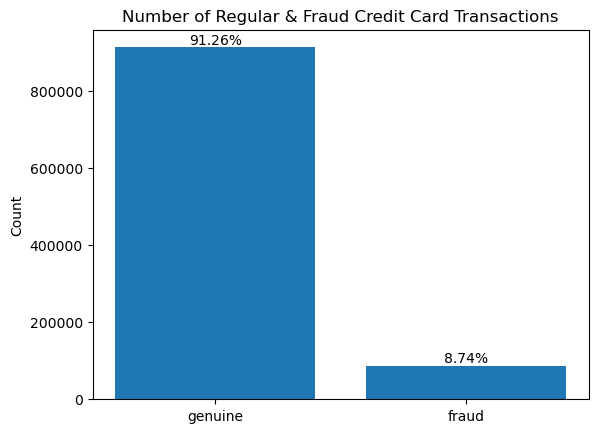

In [7]:
labels = ["genuine", "fraud"]
counts = raw_df["fraud"].value_counts().to_list()
proportion = counts / np.sum(counts) * 100

bar = plt.bar(labels, counts)
plt.ylabel("Count")
plt.title("Number of Regular & Fraud Credit Card Transactions")

# add text inside each bar
for idx, rect in enumerate(bar):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{proportion[idx]:.2f}%', ha='center', va='bottom')

# display the chart
plt.show()

In [8]:
counts

[912597, 87403]

# kNN Classifier

As previously discussed in the preliminary data analysis, the credit card fraud data set is highly imbalanced, with only 87,403 frauds observations of of 1000000 observations. Since kNN classification is a non-parametric algorithm, applying upsampling techniques like SMOTE would only increase the runtime of making predictions. Therefore, random downsampling will be employed to both increase efficiency and maintain a 50% ratio of each class.

In [9]:
# Stratified sampling on the class
X_train, X_test, y_train, y_test = train_test_split(
    raw_df.drop("fraud", axis = 1), 
    raw_df["fraud"], 
    test_size=0.80, 
    random_state=123, 
    stratify=raw_df["fraud"]
)
X_train.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
679281,14.228889,1.639855,4.104065,1.0,1.0,0.0,0.0
414524,19.058904,1.409901,3.408421,1.0,1.0,0.0,1.0
778192,2.646068,1.984384,2.859258,1.0,1.0,0.0,1.0
495061,12.625542,0.060618,1.035773,1.0,1.0,0.0,0.0
158233,14.586982,1.332998,2.657770,1.0,0.0,0.0,0.0


In [10]:
class_count(y_train)

,Class,Count
0,Non-Fraud,182519
1,Fraud,17481


Table X: A count of each class type in X_train

In [11]:
# Separate majority and minority classes
majority_class = X_train[y_train == 0]
minority_class = X_train[y_train == 1]

# Sample the majority class to balance the data
n_samples = len(minority_class)
majority_sampled = majority_class.sample(n=n_samples, replace=False, random_state=123)

# Concatenate the minority and sampled majority class dataframes
X_train_balanced = pd.concat([minority_class, majority_sampled], axis=0)
y_train_balanced = pd.Series([1] * n_samples + [0] * n_samples)
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced)

In [12]:
class_count(y_train_balanced)

,Class,Count
0,Non-Fraud,17481
1,Fraud,17481


Table X: The newly balanced training data

kNN is an algorithm that relies on the distances between the observations to classify new instances. If the scales of the different features in the data set are not normalized, then the features with larger scales will dominate the distance metric which make it difficult for features with smaller scales to contribute meaningfully to the classification. In the case of credit card fraud, `distance_from_home` has a range of 10632.72 unit which is far large than the range our binary attributes. For this reason, the data will be scaled with `StandardScaler` before any other steps.

The process of selecting predictors and tuning hyperparameters are closely related. It may be the case that a certain number of predictors would work well for a certain k value but poorly for other k values, so in order to find the optimal number of predictors we have to test it with several k values. By utilizing a 5-fold cross-validation and testing 35 combinations of predictors and k values, we can concurrently try different pairs of k value and predictors. In regards to predictor selection, we will be using `SelectKBest` to perform univariate feature selection using the ANOVA statistical test. Each potential predictor will be analyzed with our class to determine if there were a statistically significant relationship between the two.

In [13]:
# Define the hyperparameters to tune
param_grid = {
    'selectkbest__k': [1, 2, 3, 4, 5, 6, 7],
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 15]
}

knn_pred_selection_clf = make_pipeline(
    StandardScaler(),
    SelectKBest(score_func=f_classif),
    KNeighborsClassifier()
)

knn_pred_selection_res = tune(
    param_grid=param_grid, 
    pipeline=knn_pred_selection_clf, 
    X_train=X_train_balanced, 
    y_train=y_train_balanced, 
    scoring_func='f1_macro'
)

/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be 

In [14]:
knn_pred_selection_res.sort_values(by='Mean Test Score', ascending = False).head(10)

,Mean Test Score,selectkbest__k,kneighborsclassifier__n_neighbors
6,0.994308,3,7
13,0.993622,5,7
20,0.992906,7,7
27,0.992649,9,7
34,0.991505,15,7
5,0.990475,3,6
12,0.989645,5,6
19,0.989331,7,6
26,0.988673,9,6
33,0.986871,15,6


Table X: The 10 hyperparamter combinations that give the most efficient validation score

# Todo replace Table X with the table number of the above table
Table X notably shows that the top 5 accurate pair of hyperparameters use all 7 predictors from our original data set. That means that each of the predictors are an important component to correctly classifying the label of any incoming transactions. We will now look closer into different k values over a larger range that what is shown in Table X by looking at odd values between [3, 69]

In [15]:
param_grid = {
    'kneighborsclassifier__n_neighbors': [2*i + 1 for i in range(1, 35)]
}

knn_hyperparameter_selection_clf = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier())

# Perform grid search with 5-fold cross validation
knn_hyperparameter_selection_res = tune(
    param_grid=param_grid, 
    pipeline=knn_hyperparameter_selection_clf, 
    X_train=X_train_balanced, 
    y_train=y_train_balanced, 
    scoring_func='f1_macro'
)

knn_hyperparameter_selection_res

/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be 

,Mean Test Score,kneighborsclassifier__n_neighbors
0,0.994308,3
1,0.993622,5
2,0.992906,7
3,0.992649,9
4,0.992334,11
5,0.991991,13
6,0.991505,15
7,0.991219,17
8,0.990961,19
9,0.990561,21


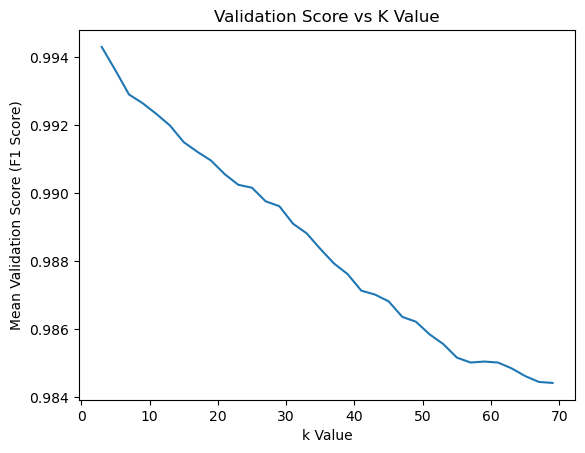

In [16]:
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the data as a line chart
ax.plot(
    knn_hyperparameter_selection_res["kneighborsclassifier__n_neighbors"],
    knn_hyperparameter_selection_res["Mean Test Score"]
)

# Set the title and axis labels
ax.set_title("Validation Score vs K Value")
ax.set_xlabel("k Value")
ax.set_ylabel("Mean Validation Score (F1 Score)")

# Show the chart
plt.show()

As shown from the above graph, most k values are very accurate in determining the transaction label only differing by a percent. We've decided to use a k value of 3 because it yielded the most accurate score in combination with out predictor selection as shown in table X (same value as the todo from above).

The final kNN classifier can know be trained so we can test it on our testing data.

In [17]:
knn_clf = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors = 3))

knn_clf.fit(X_train_balanced, y_train_balanced)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))])

In [18]:
knn_pred = knn_clf.predict(X_test)
knn_f1score = f1_score(y_test, knn_pred)
knn_f1score

/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


0.9584970462975683

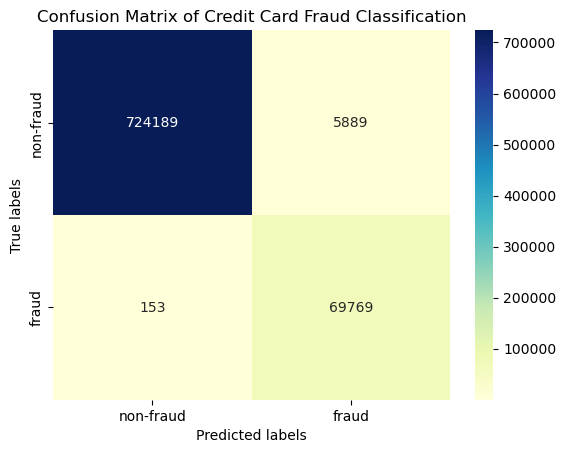

In [19]:
conf_mat_maker(y_test, knn_pred)

# Todo include analysis of results, talk about accuracy, f1 score, if this is good enough, possible reasons from high fraud misclassifications.

# Support Vector Machines

Next we'll analyze the effectiveness of support vector machine classifiers in predicting credit card fraud. The two forms of kernels that we will explore are linear kernels and radial basis function kernels. If our data set is linearly separable, a linear kernel svm would be ideal because it's a parametric model which means it's only required to store a fixed number parameters, the coefficients of the hyperplane that separates the datas into non fraud and fraud. While it's possible to model more complex data using an RBF kernel, because it's a non parametric model, the cost grows with the size of our training data, which is not ideal in our case due to the number of transactions.

Similar to kNN, we will have to deal with the unbalanced data set. In the case of SVM it is possible tp use the `class_weight` argument to add bias to the minority class to balance the data set but this also means that the algorithm with need to be fitted with 200k training examples. Due to the computational limitations of our computer, we will reuse the downsampled data that we used in kNN classifier. Additionally, it is necessary to normalize the data because SVM is a distance based algorithm that tries to maximize the distance between the hyperplane and the support vectors.

We'll first begin creating our linear SVM classifier, by tuning our regularization hyperparameter `C`.

In [20]:
param_grid = {
    'linearsvc__C': [0.1, 1, 10, 100, 1000]
}

# Create an SVM classifier with a linear kernel
linear_svm_hyperparameter_selection_clf = make_pipeline(StandardScaler(), LinearSVC(max_iter=1000, random_state=123))

# Perform grid search with 5-fold cross validation
linear_svm_hyperparameter_selection_res = tune(
    param_grid=param_grid,
    pipeline=linear_svm_hyperparameter_selection_clf,
    X_train=X_train_balanced,
    y_train=y_train_balanced,
    scoring_func='f1_macro'
)

linear_svm_hyperparameter_selection_res

/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: Conv

,Mean Test Score,linearsvc__C
0,0.932954,0.1
1,0.935270,1.0
2,0.938756,10.0
3,0.942420,100.0
4,0.880854,1000.0


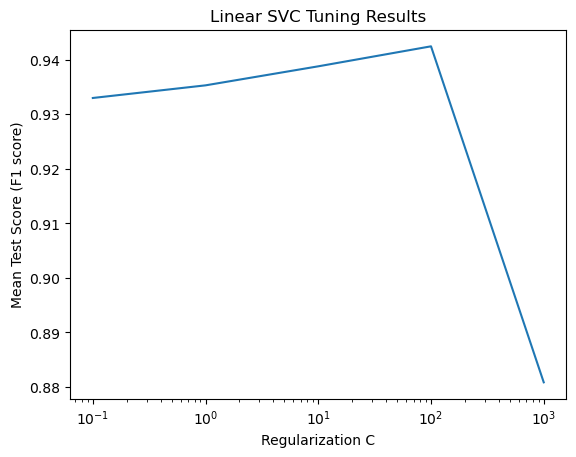

In [21]:
plt.plot(
    linear_svm_hyperparameter_selection_res["linearsvc__C"],
    linear_svm_hyperparameter_selection_res["Mean Test Score"]
)

# Sets log scale for regularization C
plt.xscale("log")

# Axis and Title labels
plt.xlabel("Regularization C")
plt.ylabel("Mean Test Score (F1 score)")
plt.title("Linear SVC Tuning Results")

plt.show()

The F1 score is optimized between `C = 10` and `C = 100`. Since a larger regularization constant biases. For our final linear support vector classifier, we will use `C = 10` as the larger the regularization parameter is the more likely it is to overfit the training data. 

In [22]:
# Fit the classifier to the training data
linear_svm_clf = make_pipeline(StandardScaler(), LinearSVC(max_iter=5000, random_state=123, C=10))
linear_svm_clf.fit(X_train_balanced, y_train_balanced)

linear_svm_pred = linear_svm_clf.predict(X_test)

linear_svm_f1score = f1_score(y_true=y_test, y_pred=linear_svm_pred)
linear_svm_f1score

/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.7179073657369823

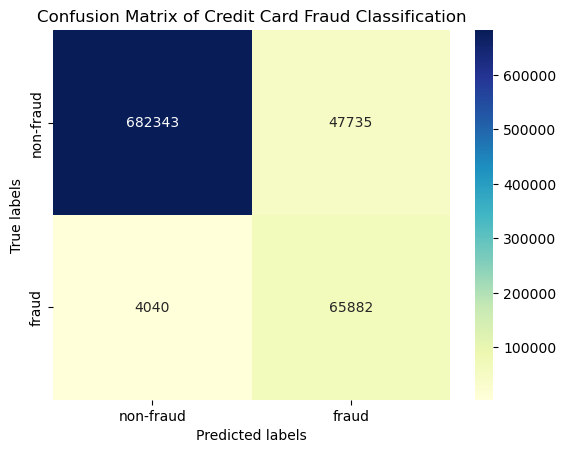

In [23]:
conf_mat_maker(y_test, linear_svm_pred)

* Discussion of results should be similar to the things you'd include in knn in terms of how well it did.
* The obvious thing to note is it does a poor job predicting fraud cases which signify the dataset is not linearly separable. (There's no good hyperplane to fit.)
* Then include something about trying rbf which allows us to model non parametric data.

In [24]:
param_grid = {
    'svc__C': [0.1, 1, 100, 1000]
}

# Create an SVM classifier with a rbf kernel
rbf_svm_hyperparameter_selection_clf = make_pipeline(StandardScaler(), SVC(max_iter=1000, random_state=123, kernel='rbf'))

# Perform grid search with 5-fold cross validation
rbf_svm_hyperparameter_selection_res = tune(
    param_grid=param_grid,
    pipeline=rbf_svm_hyperparameter_selection_clf,
    X_train=X_train_balanced,
    y_train=y_train_balanced,
    scoring_func='f1_macro'
)

rbf_svm_hyperparameter_selection_res

/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: 

,Mean Test Score,svc__C
0,0.893556,0.1
1,0.975247,1.0
2,0.993192,100.0
3,0.984955,1000.0


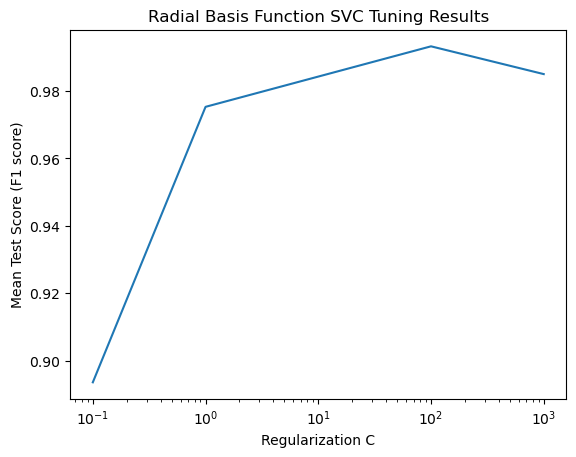

In [25]:
plt.plot(
    rbf_svm_hyperparameter_selection_res['svc__C'],
    rbf_svm_hyperparameter_selection_res["Mean Test Score"]
)

# Sets log scale for regularization C
plt.xscale("log")

# Axis and Title labels
plt.xlabel("Regularization C")
plt.ylabel("Mean Test Score (F1 score)")
plt.title("Radial Basis Function SVC Tuning Results")

plt.show()

The F1 score only seems to be decreasing after `C=100` so this would be the optimal regularization hyperparameter.

In [26]:
# Fit the classifier to the training data
rbf_svm_clf = make_pipeline(StandardScaler(), SVC(max_iter=5000, random_state=123, C=100, kernel='rbf'))
rbf_svm_clf.fit(X_train_balanced, y_train_balanced)

rbf_pred = rbf_svm_clf.predict(X_test)

rbf_svm_f1score = f1_score(y_true=y_test, y_pred=rbf_pred)
rbf_svm_f1score

/Users/user/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


0.9523218632176776

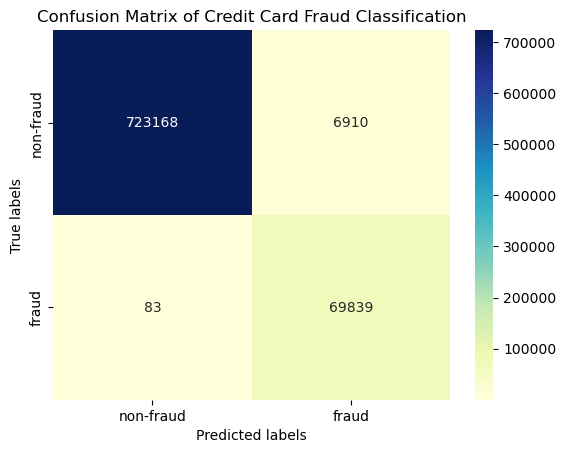

In [27]:
conf_mat_maker(y_test, rbf_pred)

* Talk about how this does a better job than linear regression.

# Decision Tree Classifier

The decision tree model is an algorithm that is constructed as a tree-like structure of decisions and their consequences.

In a decision tree, each internal node represents a test on an attribute, each branch represents the outcome of the test, and each leaf node represents a decision or a classification. The model starts at the root node and follows a path through the tree based on the values of the input features until it reaches a leaf node that corresponds to the predicted output value.

The decision tree algorithm is a top-down, greedy approach that recursively splits the data into smaller and more homogeneous subsets based on the values of the input features, with the goal of maximizing the purity of the resulting subsets. The algorithm uses a measure of impurity, such as entropy or Gini impurity, to evaluate the quality of each split and to select the best split at each node.

Decision tree model is easy to understand and interpret, able to handle both categorical and numerical data, and able to capture complex nonlinear relationships. However, it can also suffer from overfitting, instability, and sensitivity to the choice of hyperparameters and input features.

Below we will try different resampling methods and evaluate their performance for a decision tree model.

In [28]:
# Split the data into features (X) and target variable (y)
X = raw_df.drop('fraud', axis=1)
y = raw_df['fraud']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=123)

# Define the different resampling techniques to compare
resample_techniques = [
    ('Random undersampling', RandomUnderSampler(random_state=123)),
    ('Random oversampling', RandomOverSampler(random_state=123)),
    ('SMOTE', SMOTE(random_state=123))
]

# Define the decision tree classifier
clf = DecisionTreeClassifier(random_state=123)

# Loop over the different resampling techniques and fit the decision tree model
for name, resample in resample_techniques:
    pipeline2 = Pipeline([('resample', resample), ('clf', clf)])
    pipeline2.fit(X_train, y_train)
    y_pred = pipeline2.predict(X_test)
    report = classification_report(y_test, y_pred)
    print(f'Resampling technique: {name}')
    print(mean_std_cross_val_scores(
    pipeline2, X_train, y_train, return_train_score=True, scoring=["f1","accuracy","precision","recall"]
))

Resampling technique: Random undersampling
fit_time           0.115 (+/- 0.002)
score_time         0.086 (+/- 0.003)
test_f1            0.998 (+/- 0.001)
train_f1           0.998 (+/- 0.000)
test_accuracy      1.000 (+/- 0.000)
train_accuracy     1.000 (+/- 0.000)
test_precision     0.996 (+/- 0.002)
train_precision    0.997 (+/- 0.000)
test_recall        1.000 (+/- 0.000)
train_recall       1.000 (+/- 0.000)
dtype: object
Resampling technique: Random oversampling
fit_time           0.630 (+/- 0.009)
score_time         0.088 (+/- 0.003)
test_f1            1.000 (+/- 0.000)
train_f1           1.000 (+/- 0.000)
test_accuracy      1.000 (+/- 0.000)
train_accuracy     1.000 (+/- 0.000)
test_precision     1.000 (+/- 0.000)
train_precision    1.000 (+/- 0.000)
test_recall        1.000 (+/- 0.000)
train_recall       1.000 (+/- 0.000)
dtype: object
Resampling technique: SMOTE
fit_time           1.221 (+/- 0.082)
score_time         0.089 (+/- 0.001)
test_f1            0.999 (+/- 0.000)
train_f1

From the table above, we can see that the random oversampling method is the most efficient and effective method to deal with the imbalanced dataset for a decision tree model. Let's try the cost sensitive learning resampling method below.

In [29]:
# cost sensitive learning

# Define the class weights
class_weights = {0: 1, 1: 5}  # Assign higher weight to the minority class

# Train a decision tree model with class weights
clf = DecisionTreeClassifier(class_weight=class_weights, random_state=123)
clf.fit(X_train, y_train)

# Make predictions on the testing set
dt_pred = clf.predict(X_test)

# Print classification report
print(classification_report(y_test, dt_pred))
print(mean_std_cross_val_scores(clf, X_train, y_train, return_train_score=True, scoring=["f1_macro","accuracy","precision","recall"]))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    730119
         1.0       1.00      1.00      1.00     69881

    accuracy                           1.00    800000
   macro avg       1.00      1.00      1.00    800000
weighted avg       1.00      1.00      1.00    800000

fit_time           0.382 (+/- 0.020)
score_time         0.092 (+/- 0.006)
test_f1_macro      1.000 (+/- 0.000)
train_f1_macro     1.000 (+/- 0.000)
test_accuracy      1.000 (+/- 0.000)
train_accuracy     1.000 (+/- 0.000)
test_precision     1.000 (+/- 0.000)
train_precision    1.000 (+/- 0.000)
test_recall        1.000 (+/- 0.000)
train_recall       1.000 (+/- 0.000)
dtype: object


In [30]:
decision_tree_f1score = f1_score(y_true=y_test, y_pred=dt_pred)
decision_tree_f1score

0.9995635281238149

Cost-sensitive learning is a technique that aims to address the issue of class imbalance by assigning different misclassification costs to different classes. In the context of a binary classification problem, cost-sensitive learning involves assigning a higher cost to misclassifying the minority class (i.e., the positive class in the case of fraud detection) than to misclassifying the majority class (i.e., the negative class in the case of fraud detection).

In reality, the cost of misclassifying a fraudulent transaction as non-fraudulent could be much higher than the cost of misclassifying a non-fraudulent transaction as fraudulent. This is because misclassifying a fraudulent transaction as non-fraudulent can lead to financial losses for the company, while misclassifying a non-fraudulent transaction as fraudulent might only result in additional investigation or inconvenience for the customer.

From the performance and f1 scores of all the methods, we will choose the cost-sensitive learning technique for resampling.

# Random Forest Classifier

Random Forest is an algorithm that uses a collection of decision trees to improve the predictive accuracy and generalization of the model. It is an ensemble learning technique that combines multiple decision trees and aggregates their results to make a final prediction. Each decision tree in the forest is trained on a different subset of the data, using a random selection of features at each split. This overcomes the shortcoming of the decision tree classifier mentioned earlier.

During prediction, each decision tree in the forest independently generates a prediction, and the final prediction is made by taking a majority vote across all the trees. This approach reduces the risk of overfitting and makes the model more robust to noise and outliers in the data.


# Conclusion

In [31]:
pd.DataFrame(
    {
        "Classifier": ["Knn", "Linear SVC", "RBF SVC", "Decision Tree", "Random Forest"],
        "Test F1-Score": [knn_f1score, linear_svm_f1score, rbf_svm_f1score, decision_tree_f1score, 0],
        "Parametric or Non Parametric": ["Non Parametric", "Parametric", "Non Parametric", "Parametric", "Parametric"],
    }
)

,Classifier,Test F1-Score,Parametric or Non Parametric
0,Knn,0.958497,Non Parametric
1,Linear SVC,0.717907,Parametric
2,RBF SVC,0.952322,Non Parametric
3,Decision Tree,0.999564,Parametric
4,Random Forest,0.000000,Parametric


Maybe include all 5 confusion matrices and have this section be the location where compare between each type of model.